In [126]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import copy
import geopandas as gp

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import diff_nmf
import grid_search
import data_generator
import nmf
from diff_nmf import diff_nmf
from grid_search import gridSearcher
from data_generator import *
from nmf import nmf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Graphing preliminaries

In [120]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1

In [121]:
from collections import OrderedDict

linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

In [122]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [123]:
h_list = ["ffb950","ffad33","ff931f","ff7e33","fa5e1f","ec3f13","b81702","a50104","8e0103","7a0103"]
my_pal = get_continuous_cmap(h_list)

### The Data

In [124]:
# importing
dataset = pd.read_csv(os.path.join(par, "covid_dataset/us_state/dataset.csv"), index_col = 0).astype(np.float64)
laplacian = pd.read_csv(os.path.join(par, "covid_dataset/us_state/laplacian.csv"), index_col = 0)
population = pd.read_csv(os.path.join(par, "covid_dataset/us_state/population.csv"), index_col = 0)
population.loc[:, 'population_estimate'] = population.loc[:, 'population_estimate'].astype(np.float64)

# json file with geographic info for each state -- required for graphing
state_map = os.path.join(par, 'covid_dataset/us_state/geography.json')

In [125]:
# NOTE: For the purposes of this experiment I am not including Alaska, Hawaii, or Puerto Rico in the data. This is simply because our current description of diffusion 
# is very much dependent on adjacency between locations. Because its unclear how these regions should be included in the adjacency graph and because they
# share no land borders with other regions in the data, we have chosen to simply leave them out for now. We hope that in the future we will have better
# diffusion processes or adjacency graphs so that they may be included. 

dataset = dataset.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)

laplacian = laplacian.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)
laplacian = laplacian.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 0)

In [127]:
# normalize the data set by population (i.e. divide each column by that states population)
for col in dataset.columns:
    dataset.loc[:,col] /= population.loc[population.name == col, 'population_estimate'].item() 
    
# For further preparation, perfrom isotonic regression on each of the columns
# COVID-19 cumulative case counts should be always increasing from day to day, but because this is real data there are often errors in reporting
# Isotonic regression simply fixes these small errors giving nicer wave-like case counts
# IF a location does not contain any error, nothing is changed.

dataset = iso_regression(dataset)

### Grid Search

**Given the computational cost of a grid search I have chosen to exclude it from the notebook. I have tried to make the process simple and easy to follow by including the grid_search.py file in the repository.** To find the best set of parameters for which diffusion-nmf performs best we chose to try a range of different rank and beta (spread parameter) combinations. We choose final values by analyzing the trends shown in the graph and finding parameter combinations that give small relative error. 

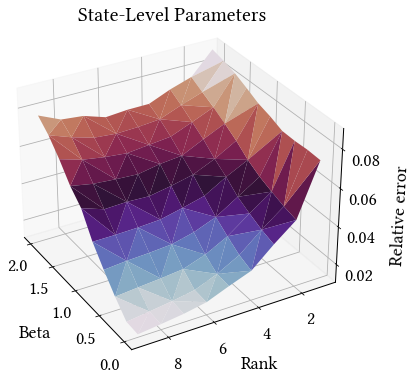

In [128]:
state_grid = pd.read_csv(os.path.join(par, "covid_dataset/us_state/grid_search_results/diff_rank_beta_error.csv"))
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(state_grid['beta'], state_grid['rank'], state_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("State-Level Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

### Results:

In [129]:
# A quick function to rescale the results for better presentation
# does not affect trends in the output
def rescale(X,V,K = None):
    X = copy.deepcopy(X)
    V = copy.deepcopy(V)

    maxer = np.amax(X)
    X /= maxer
    V *= maxer
    
    return X,V

In [130]:
# prepare parameters
rank = 5
beta = 1
K = np.linalg.inv(np.identity(len(laplacian)) + beta * laplacian.to_numpy())

# diffusion nmf (takes a few minutes or so)
dNMF = diff_nmf(n_components = rank, kernel = K, n_iter = 200000  , tol = 1e-10)
X,V = dNMF.fit_transform(dataset)

Max iterations reached, increase to converge on given tolerance


In [131]:
# regular nmf for comparison
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
W,H = nmfer.fit_transform(dataset)

Max iterations reached, increase to converge on given tolerance


In [132]:
#rescaling
X,V = rescale(X,V,K)
X = pd.DataFrame(X, index = dataset.index)
V = pd.DataFrame(V, columns = dataset.columns)

W,H = rescale(W,H)
W = pd.DataFrame(W, index = dataset.index)
H = pd.DataFrame(H, columns = dataset.columns)

In [135]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [0,1,2,3,4]
X = X[reorder]
X.columns = standard
V = V.reindex(reorder)
V.index = standard 

# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [2,4,1,3,0]
W = W[reorder]
W.columns = standard
H = H.reindex(reorder)
H.index = standard 

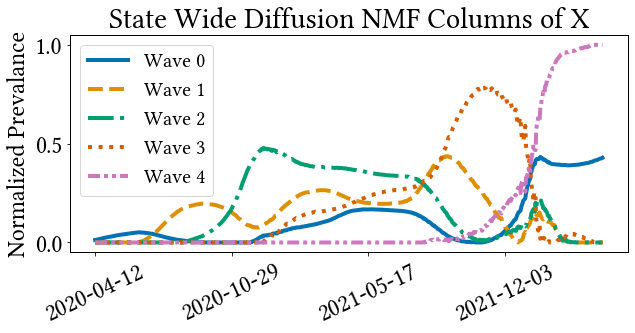

In [138]:
X.columns = ["Wave " + str(i) for i in range(rank)]

plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
X.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(X.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalance")
plt.title("State Wide Diffusion NMF Columns of X")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

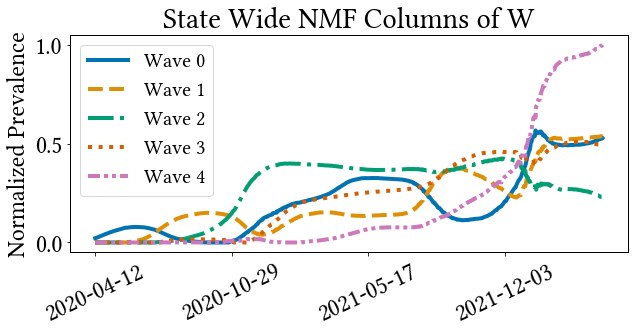

In [139]:
W.columns = ["Wave " + str(i) for i in range(rank)]

plt.rcParams["font.size"] = 24
W.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(W.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()

plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalence")
plt.title("State Wide NMF Columns of W")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/state_nmfX.pdf',  bbox_inches = "tight")
plt.show()

Text(0.5, 1.0, 'Row 1 of V (D-NMF)')

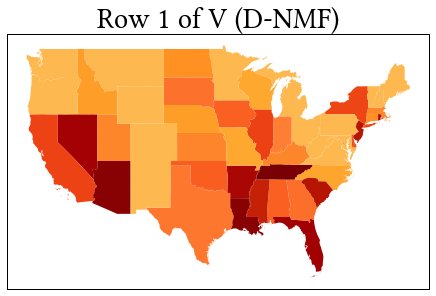

In [140]:
plt.rcParams["font.size"] = 24
stateMap = gp.read_file(state_map)

# CHANGE PARAMETER TO SEE DIFFERENT MAPS:
row_num = 1

val_col1 = []
for i in stateMap["NAME"]:
    try:
        val_col1.append(V.loc[row_num,i])
    except:
        pass
        val_col1.append(np.nan)


stateMap['val1'] = val_col1

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

stateMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of V (D-NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_V' + str(row_num) + '.pdf', bbox_inches = "tight")

Text(0.5, 1.0, 'Row 1 of H (NMF)')

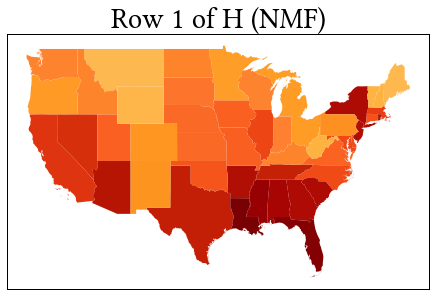

In [141]:
row_num = 1

H_col = []
for i in stateMap["NAME"]:
    try:
        H_col.append(H.loc[row_num,i])
    except:
        H_col.append(np.nan)

stateMap['val'] = H_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
stateMap.plot(column='val',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of H (NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_H' + str(row_num) + '.pdf', bbox_inches = "tight")

### Error Checking

The following was ran through the process of another grid search. However this time the beta was kept at a constant value of 1. This was done so that a comparison with the error seen with NMF would be allowed. 

In [142]:
state_diff_error = pd.read_csv(os.path.join(par, "covid_dataset/us_state/grid_search_results/diff_rank_error.csv"))
state_nmf_error = state_grid = pd.read_csv(os.path.join(par, "covid_dataset/us_state/grid_search_results/nmf_rank_error.csv"))

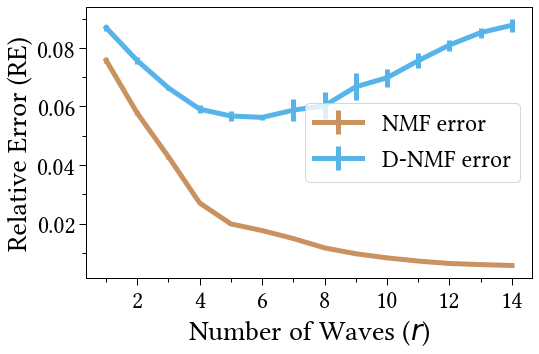

In [143]:
c_pal = sns.color_palette("colorblind", 10)
plt.rcParams['legend.fontsize'] = 24
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, state_nmf_error["relative error"], state_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, state_diff_error["relative error"], state_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_error.pdf', bbox_inches = "tight")